In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d subirbiswas19/skin-disease-dataset

import zipfile
zip_ref = zipfile.ZipFile('/content/skin-disease-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/subirbiswas19/skin-disease-dataset
License(s): CC0-1.0
skin-disease-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.applications import VGG19
import matplotlib.pyplot as plt
import cv2
import os

In [ ]:
# Load dataset for multi-class classification
train_ds = tf.keras.utils.image_dataset_from_directory(
    directory=r'/content/skin-disease-datasaet/train_set',
    labels='inferred',
    label_mode='int',  # For multi-class, use integer labels
    batch_size=32,
    image_size=(256, 256)
)

validation_ds = tf.keras.utils.image_dataset_from_directory(
    directory=r'/content/skin-disease-datasaet/test_set',
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(256, 256)
)

Found 924 files belonging to 8 classes.
Found 233 files belonging to 8 classes.


In [ ]:

# Load the VGG16 model pre-trained on ImageNet, exclude the top layers
vgg19_base = VGG19(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze the pre-trained layers so they won't be updated during training
vgg19_base.trainable = False

# Define the custom model with VGG16 as the base
num_classes = 8  # Change this number based on the number of classes to classify

model = Sequential()

# Add the VGG16 base model
model.add(vgg19_base)

# Flatten the output from the VGG16 base
model.add(Flatten())

# Add custom Dense layers with BatchNormalization, Dropout, and LeakyReLU for better performance
model.add(Dense(512))
model.add(BatchNormalization())
model.add(tf.keras.layers.LeakyReLU())
model.add(Dropout(0.5))

model.add(Dense(256))
model.add(BatchNormalization())
model.add(tf.keras.layers.LeakyReLU())
model.add(Dropout(0.5))

In [ ]:
# Output layer for multi-class classification with 'softmax'
model.add(Dense(num_classes, activation='softmax'))  # num_classes represents the number of diseases

# Compile the model with sparse categorical cross-entropy for multi-class classification
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
# Learning rate scheduler to gradually decrease the learning rate
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
         return float(lr * tf.math.exp(-0.1).numpy())

lr_scheduler = LearningRateScheduler(scheduler)

In [ ]:
# Train the model
history = model.fit(train_ds, epochs=20, validation_data=validation_ds, callbacks=[early_stopping, lr_scheduler])

Epoch 1/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 16s 388ms/step - accuracy: 0.5982 - loss: 1.2330 - val_accuracy: 0.8884 - val_loss: 0.9432 - learning_rate: 0.0010
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 15s 255ms/step - accuracy: 0.9425 - loss: 0.2296 - val_accuracy: 0.9227 - val_loss: 0.4835 - learning_rate: 0.0010
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 254ms/step - accuracy: 0.9691 - loss: 0.1212 - val_accuracy: 0.9356 - val_loss: 0.3176 - learning_rate: 0.0010
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 11s 292ms/step - accuracy: 0.9855 - loss: 0.0697 - val_accuracy: 0.9442 - val_loss: 0.2690 - learning_rate: 0.0010
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 254ms/step - accuracy: 0.9931 - loss: 0.0404 - val_accuracy: 0.9356 - val_loss: 0.2492 - learning_rate: 0.0010
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 252ms/step - accuracy: 0.9997 - loss: 0.0191 - val_accuracy: 0.9313 - val_loss: 0.2377 - learning_rate: 0.0010
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 245ms/step - accuracy: 0.9974 - loss: 0.02

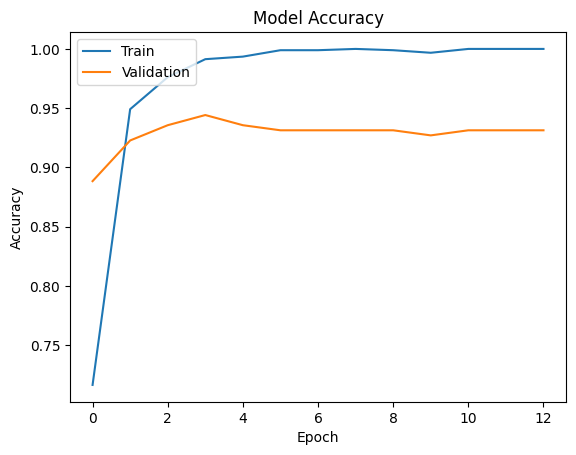

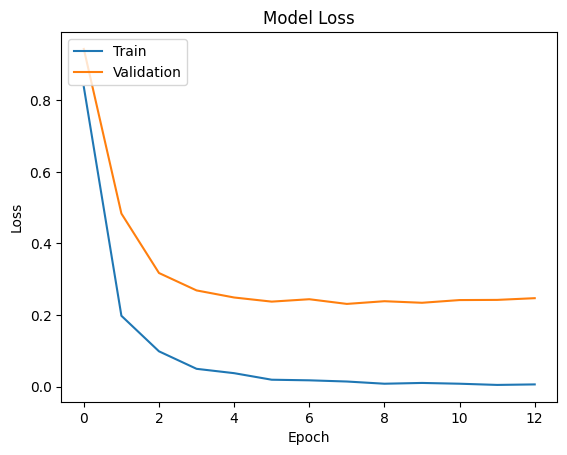

In [ ]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')  # 'Validation' should be a string
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')  # 'Validation' should be a string
plt.show()

In [ ]:
# Multi-Class Prediction on a New Image
def predict_image(image_path):
    # Load and preprocess the image
    test_image = cv2.imread(image_path)

    if test_image is None:
        print("Error: Image not loaded, check if the file path is correct.")
        return

    # Resize the image to match the input size of the model
    test_image = cv2.resize(test_image, (256, 256))
    test_image = test_image / 255.0  # Normalize image
    test_image = tf.expand_dims(test_image, axis=0)  # Add batch dimension

    # Make prediction
    prediction = model.predict(test_image)

    # Convert prediction to the most likely class
    predicted_class = tf.argmax(prediction[0])

    # Assuming there are 5 diseases (replace with actual disease names)
    disease_names = ['Chickenpox', 'Eczema', 'Ringworm', 'Disease4', 'Disease5','Chickenpox', 'Eczema', 'Ringworm']

    print("Predicted Disease:", disease_names[predicted_class])

    # Display the image with predicted label
    plt.imshow(cv2.cvtColor(test_image[0], cv2.COLOR_BGR2RGB))
    plt.title(f'Prediction: {disease_names[predicted_class]}')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicted Disease: Disease6


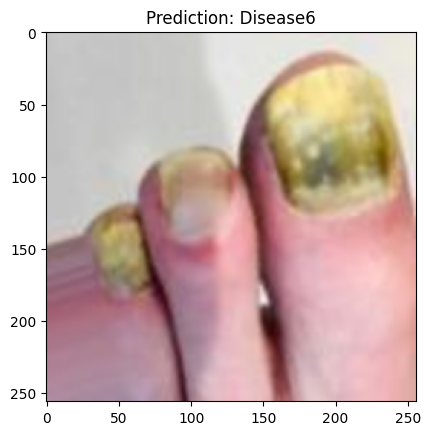

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

def predict_image(image_path):
    # Load and preprocess the image
    test_image = cv2.imread(image_path)

    if test_image is None:
        print("Error: Image not loaded, check if the file path is correct.")
        return

    # Resize the image to match the input size of the model
    test_image = cv2.resize(test_image, (256, 256))
    test_image_normalized = test_image / 255.0  # Normalize image
    test_image_normalized = tf.expand_dims(test_image_normalized, axis=0)  # Add batch dimension

    # Make prediction
    prediction = model.predict(test_image_normalized)

    # Convert prediction to the most likely class
    predicted_class = tf.argmax(prediction[0])

    # Assuming there are 5 diseases (replace with actual disease names)
    disease_names = ['d1', 'd2', 'd3', 'd4', 'Disease5','Disease6', 'Disease7', 'd8', 'Disease9']

    print("Predicted Disease:", disease_names[predicted_class])

    # Display the original image with the predicted label
    plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))  # Using original test_image
    plt.title(f'Prediction: {disease_names[predicted_class]}')
    plt.show()

# Example usage of the prediction function
test_image_path = '/content/skin-disease-datasaet/test_set/FU-nail-fungus/_10_1593.jpg'  # Provide the correct image path
predict_image(test_image_path)


In [ ]:
# model.save('modelkietvgg19_savv.keras')


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Save the zip file to Google Drive
!cp modelkietvgg19_savv.zip /content/drive/MyDrive/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# import shutil
# shutil.make_archive('modelkietvgg19_savv', 'zip', 'modelkietvgg19_savv')


'/content/modelkietvgg19_savv.zip'

In [ ]:
# !ls


drive			   modelkietvgg19_savv.zip  skin-disease-datasaet
modelkietvgg19_savv.keras  sample_data		    skin-disease-dataset.zip


In [ ]:
!cp modelkietvgg19_savv.zip /content/drive/MyDrive/


In [ ]:
# from google.colab import files
# files.download('modelkietvgg19_savv.keras')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!cp modelkietvgg19_savv.keras /content/drive/MyDrive/
